# Random Forest - Top model according to the SCPM of -3.32

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "209",
    "Plant": "AM",
    "Features": "Chemical + Properties CS Less",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/209/am.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [10]:
repeats = 3
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.983 (0.082)
MAE: -0.726 (0.048)
MAPE: -0.017 (0.001)
R2: 0.973 (0.005)


******
[TEST]
******
RMSE: -1.049 (0.072)
MAE: -0.812 (0.061)
MAPE: -0.020 (0.001)
R2: 0.968 (0.008)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2021-01-04,39.600000,40.752554,TRAIN
1,2021-01-04,44.700001,44.955922,TRAIN
2,2021-01-04,35.700001,35.009541,TRAIN
3,2021-01-04,33.400002,34.230276,TRAIN
4,2021-01-04,49.400002,47.588094,TRAIN
...,...,...,...,...
3770,2023-07-22,39.200001,40.217530,TEST
3771,2023-07-22,48.000000,48.279558,TEST
3772,2023-07-24,47.000000,48.279558,TEST
3773,2023-07-25,47.000000,46.756481,TEST


<IPython.core.display.Javascript object>

In [13]:
df_copy_merge = df_copy.reset_index(drop=True).merge(
    df_pred.reset_index(drop=True), left_index=True, right_index=True, how="inner"
)
df_copy_merge["COMPANY"] = 209
df_copy_merge["PLANT"] = "AM"

for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel("local_model_random_forest_btsscv_209_am.xlsx", index=False)
df_copy_merge.to_csv("local_model_random_forest_btsscv_209_am.csv", index=False)

<IPython.core.display.Javascript object>

In [14]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2021-01-04,39.600000,40.752554,TRAIN,CP IV-32
1,2021-01-04,44.700001,44.955922,TRAIN,CP II-F-40
2,2021-01-04,35.700001,35.009541,TRAIN,CP II-Z-32
3,2021-01-04,33.400002,34.230276,TRAIN,CP II-Z-32
4,2021-01-04,49.400002,47.588094,TRAIN,CP V-ARI
...,...,...,...,...,...
3770,2023-07-22,39.200001,40.217530,TEST,CP IV-32
3771,2023-07-22,48.000000,48.279558,TEST,CP V-ARI
3772,2023-07-24,47.000000,48.279558,TEST,CP V-ARI
3773,2023-07-25,47.000000,46.756481,TEST,CP V-ARI


<IPython.core.display.Javascript object>

In [15]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

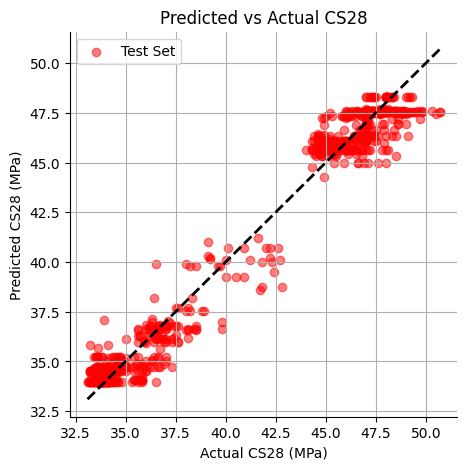

<IPython.core.display.Javascript object>

In [16]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]

# Plot Predicted vs Actual for the test set
plt.figure(figsize=(5.0, 5.0))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="red", alpha=0.5, label="Test Set"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_cm_p_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')

plt.show()
# USAR ESSE



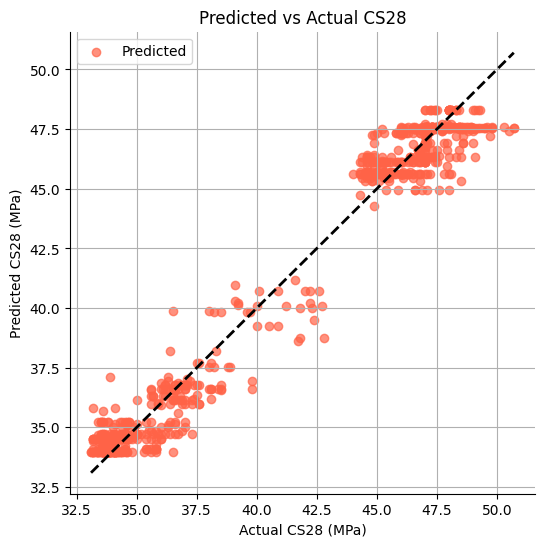

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_cm_p_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


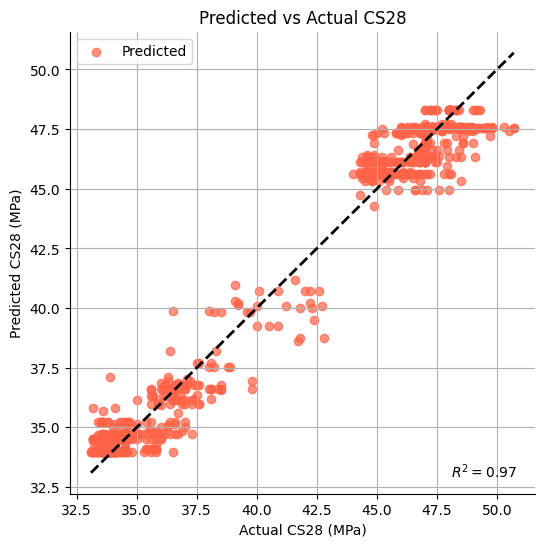

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

r2 = 0.97
plt.text(
    0.82,
    0.07,
    f"$R^2 = {r2:.2f}$",
    transform=plt.gca().transAxes,
    verticalalignment="top",
)

plt.savefig("ecics_cm_p_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [19]:
df["Cement_Type"].value_counts()

Cement_Type
CP II-Z-32    1179
CP II-F-40     941
CP V-ARI       811
CP II-F-32     355
CP II-Z-40     306
CP IV-32       184
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [20]:
df[df["Cement_Type"].eq("CP V-ARI")]["CS28"].describe()

count    811.000000
mean      47.572133
std        1.480270
min       44.000000
25%       47.000000
50%       47.500000
75%       48.350000
max       53.799999
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [21]:
test_data[
    (test_data["CS28"] > 34)
    & (test_data["CS28"] < 36)
    & (test_data["CS28_PRED"] > 42)
    & (test_data["CS28_PRED"] < 44)
]

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE


<IPython.core.display.Javascript object>

In [22]:
df_pred["CS28"][(df_pred["CS28"] < 38) & (df_pred["SET"] == "TRAIN")].describe()

count    1237.000000
mean       34.773888
std         1.237810
min        33.000000
25%        33.799999
50%        34.400002
75%        35.799999
max        37.900000
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [23]:
df_pred["CS28"][(df_pred["CS28"] > 44) & (df_pred["SET"] == "TRAIN")].describe()

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


count    1637.000000
mean       46.851662
std         1.520308
min        44.099998
25%        45.599998
50%        47.000000
75%        47.700001
max        53.799999
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

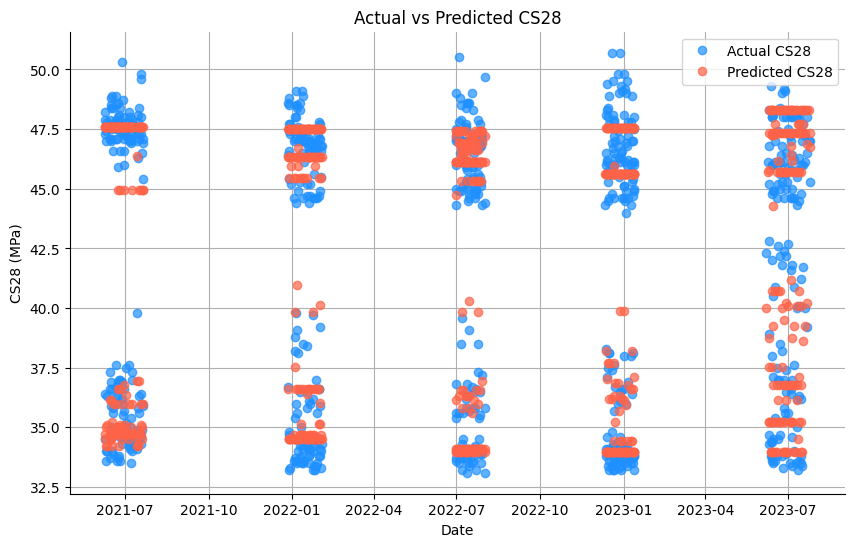

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_btiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [25]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [26]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#325,Initial setting time,Final setting time
Importances - 0,0.010120,0.002508,0.004238,0.000000,0.000000,0.000000,0.002055,0.001015,0.003915,0.009538,0.381727,0.584088,0.000000,0.000796
Importances - 1,0.000000,0.000232,0.000000,0.000160,0.012408,0.000178,0.025888,0.000646,0.014903,0.023644,0.915738,0.004789,0.000000,0.001413
Importances - 2,0.000000,0.000071,0.000438,0.000251,0.002277,0.014949,0.000143,0.000189,0.006782,0.049626,0.369078,0.556041,0.000154,0.000000
Importances - 3,0.000808,0.000637,0.000000,0.000000,0.008293,0.000000,0.000649,0.002779,0.015312,0.034260,0.014889,0.922373,0.000000,0.000000
Importances - 4,0.011702,0.000000,0.000000,0.001660,0.000000,0.014476,0.000000,0.016790,0.015329,0.036496,0.710648,0.192093,0.000000,0.000805


<IPython.core.display.Javascript object>

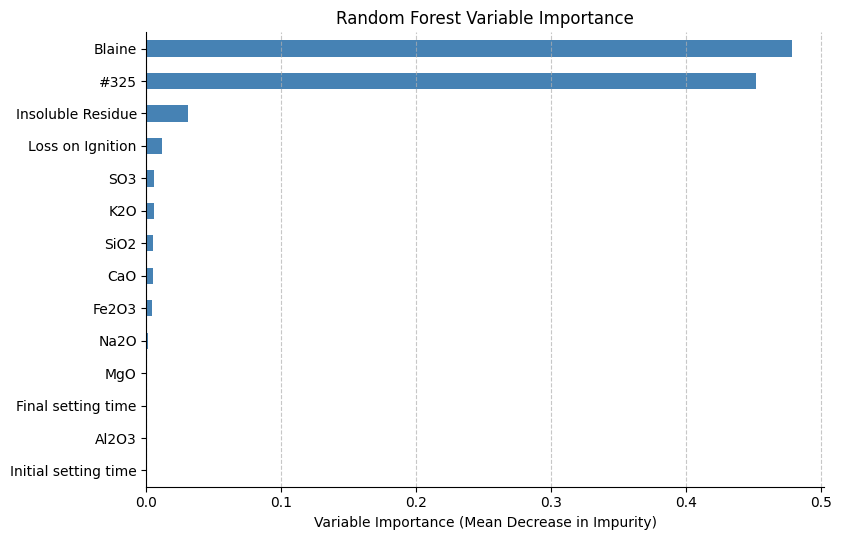

<IPython.core.display.Javascript object>

In [27]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Importance")
plt.xlabel("Variable Importance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

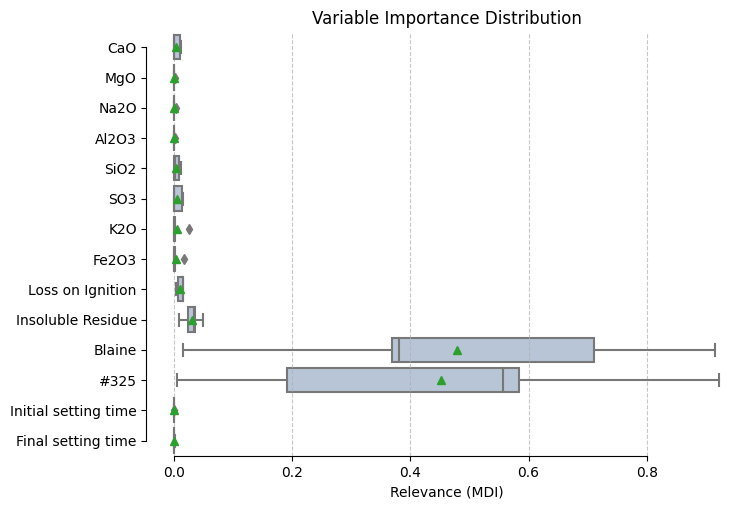

<IPython.core.display.Javascript object>

In [28]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


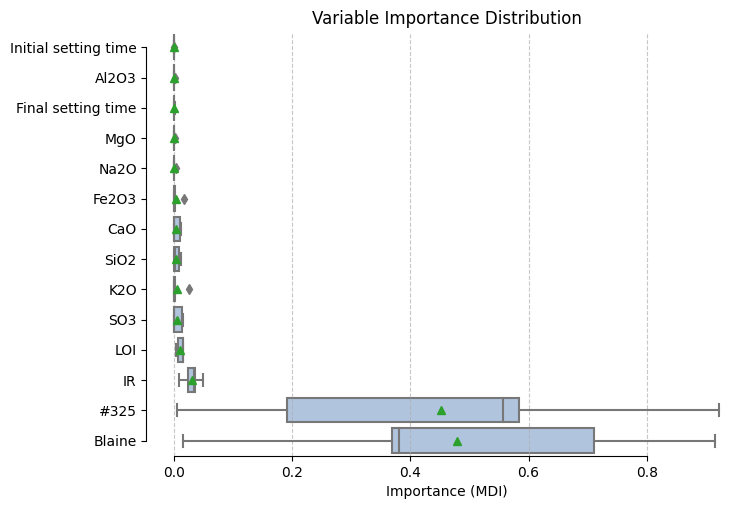

<IPython.core.display.Javascript object>

In [29]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI",
             "Insoluble Residue": "IR",
            }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig("ecics_cm_p_btiss_random_forest_scpm_best_dist_var_relevance.png", dpi=300, bbox_inches='tight')
plt.show()


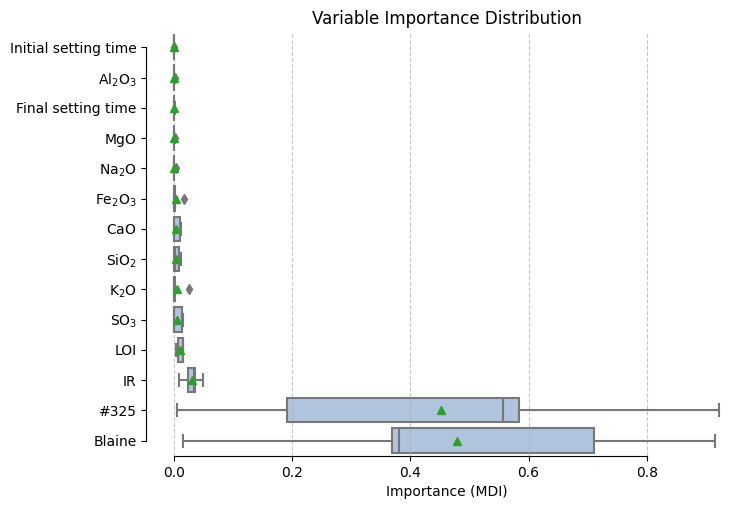

<IPython.core.display.Javascript object>

In [30]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_btiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [31]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#325,Initial setting time,Final setting time
Importances - 0,0.010120,0.002508,0.004238,0.000000,0.000000,0.000000,0.002055,0.001015,0.003915,0.009538,0.381727,0.584088,0.000000,0.000796
Importances - 1,0.000000,0.000232,0.000000,0.000160,0.012408,0.000178,0.025888,0.000646,0.014903,0.023644,0.915738,0.004789,0.000000,0.001413
Importances - 2,0.000000,0.000071,0.000438,0.000251,0.002277,0.014949,0.000143,0.000189,0.006782,0.049626,0.369078,0.556041,0.000154,0.000000
Importances - 3,0.000808,0.000637,0.000000,0.000000,0.008293,0.000000,0.000649,0.002779,0.015312,0.034260,0.014889,0.922373,0.000000,0.000000
Importances - 4,0.011702,0.000000,0.000000,0.001660,0.000000,0.014476,0.000000,0.016790,0.015329,0.036496,0.710648,0.192093,0.000000,0.000805


<IPython.core.display.Javascript object>

In [32]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,0.004526,0.005865,0.000000,0.000000,0.000808,0.010120,0.011702
MgO,5.0,0.000690,0.001046,0.000000,0.000071,0.000232,0.000637,0.002508
Na2O,5.0,0.000935,0.001856,0.000000,0.000000,0.000000,0.000438,0.004238
Al2O3,5.0,0.000414,0.000705,0.000000,0.000000,0.000160,0.000251,0.001660
SiO2,5.0,0.004596,0.005530,0.000000,0.000000,0.002277,0.008293,0.012408
SO3,5.0,0.005920,0.008028,0.000000,0.000000,0.000178,0.014476,0.014949
K2O,5.0,0.005747,0.011289,0.000000,0.000143,0.000649,0.002055,0.025888
Fe2O3,5.0,0.004284,0.007060,0.000189,0.000646,0.001015,0.002779,0.016790
Loss on Ignition,5.0,0.011248,0.005483,0.003915,0.006782,0.014903,0.015312,0.015329
Insoluble Residue,5.0,0.030713,0.015017,0.009538,0.023644,0.034260,0.036496,0.049626


<IPython.core.display.Javascript object>

In [33]:
df_importances.mean(axis=0)

CaO                     0.004526
MgO                     0.000690
Na2O                    0.000935
Al2O3                   0.000414
SiO2                    0.004596
SO3                     0.005920
K2O                     0.005747
Fe2O3                   0.004284
Loss on Ignition        0.011248
Insoluble Residue       0.030713
Blaine                  0.478416
#325                    0.451877
Initial setting time    0.000031
Final setting time      0.000603
dtype: float64

<IPython.core.display.Javascript object>

In [34]:
df_importances.std(axis=0, ddof=0)

CaO                     0.005245
MgO                     0.000936
Na2O                    0.001660
Al2O3                   0.000630
SiO2                    0.004946
SO3                     0.007180
K2O                     0.010097
Fe2O3                   0.006314
Loss on Ignition        0.004904
Insoluble Residue       0.013432
Blaine                  0.310272
#325                    0.321581
Initial setting time    0.000062
Final setting time      0.000541
dtype: float64

<IPython.core.display.Javascript object>

In [35]:
df_copy.nunique()

Date                     688
CaO                     1936
MgO                     1145
Na2O                     741
Al2O3                   1251
SiO2                    1716
SO3                     1046
K2O                      810
Fe2O3                    929
Loss on Ignition         821
Insoluble Residue       1309
Blaine                   215
#325                     158
Initial setting time      34
Final setting time        40
dtype: int64

<IPython.core.display.Javascript object>

In [36]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [37]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [38]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

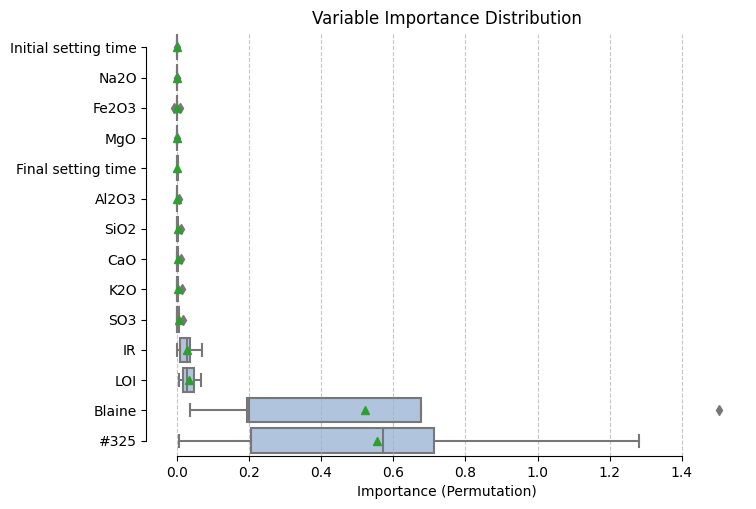

<IPython.core.display.Javascript object>

In [39]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(
    columns={
        "Loss on Ignition": "LOI",
        "Insoluble Residue": "IR",
    }
)


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

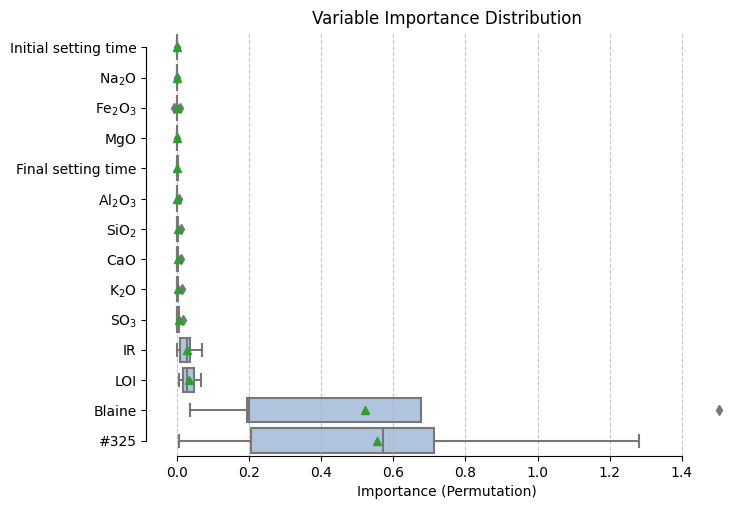

<IPython.core.display.Javascript object>

In [40]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [41]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Initial setting time,5.0,0.000069,0.000154,0.000000,0.000000,0.000000,0.000000,0.000344
Na2O,5.0,0.000081,0.000351,-0.000269,0.000000,0.000000,0.000000,0.000673
Fe2O3,5.0,0.000163,0.005976,-0.008543,-0.000106,0.000386,0.000752,0.008324
MgO,5.0,0.000196,0.000450,-0.000257,0.000000,0.000002,0.000322,0.000913
Final setting time,5.0,0.001240,0.001257,0.000000,0.000000,0.001267,0.002118,0.002813
Al2O3,5.0,0.001319,0.002997,-0.000326,0.000000,0.000000,0.000252,0.006668
SiO2,5.0,0.002795,0.004490,0.000000,0.000000,0.000436,0.003037,0.010502
CaO,5.0,0.003102,0.005218,0.000000,0.000000,0.000039,0.003416,0.012055
K2O,5.0,0.003258,0.005790,0.000000,0.000000,0.000851,0.001921,0.013520
SO3,5.0,0.004724,0.007320,0.000000,0.000000,0.000308,0.006458,0.016856


<IPython.core.display.Javascript object>

In [42]:
perm_importances_df

,Initial setting time,Na2O,Fe2O3,MgO,Final setting time,Al2O3,SiO2,CaO,K2O,SO3,IR,LOI,Blaine,#325
0,0.000000,0.000673,0.000752,0.000322,0.001267,0.000000,0.000000,0.000039,0.000000,0.000000,-0.000253,0.005698,0.200040,0.712941
1,0.000000,0.000000,-0.000106,0.000913,0.002118,-0.000326,0.003037,0.000000,0.013520,0.000308,0.008735,0.065718,1.503308,0.005636
2,0.000344,-0.000269,0.000386,0.000002,0.000000,0.000252,0.000436,0.000000,0.000851,0.016856,0.028395,0.016227,0.195484,0.572128
3,0.000000,0.000000,0.008324,-0.000257,0.000000,0.000000,0.010502,0.003416,0.001921,0.000000,0.071152,0.048570,0.035298,1.281710
4,0.000000,0.000000,-0.008543,0.000000,0.002813,0.006668,0.000000,0.012055,0.000000,0.006458,0.037263,0.029330,0.677451,0.205166


<IPython.core.display.Javascript object>

In [43]:
perm_importances_df.mean(axis=0)

Initial setting time    0.000069
Na2O                    0.000081
Fe2O3                   0.000163
MgO                     0.000196
Final setting time      0.001240
Al2O3                   0.001319
SiO2                    0.002795
CaO                     0.003102
K2O                     0.003258
SO3                     0.004724
IR                      0.029058
LOI                     0.033109
Blaine                  0.522316
#325                    0.555516
dtype: float64

<IPython.core.display.Javascript object>

In [44]:
perm_importances_df.std(axis=0, ddof=0)

Initial setting time    0.000138
Na2O                    0.000314
Fe2O3                   0.005346
MgO                     0.000403
Final setting time      0.001124
Al2O3                   0.002681
SiO2                    0.004016
CaO                     0.004667
K2O                     0.005179
SO3                     0.006547
IR                      0.024947
LOI                     0.021694
Blaine                  0.535589
#325                    0.442160
dtype: float64

<IPython.core.display.Javascript object>

In [45]:
from sklearn.metrics import make_scorer

def compute_scmp(y_true, y_pred):
    # Compute the performance metrics
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # Create a DataFrame with these metrics
    metrics_df = pd.DataFrame({
        "RMSE Test": [rmse],
        "MAE Test": [mae],
        "MAPE Test": [mape],
        "R2 Test": [r2]
    })

    # Standardize the metrics
    scaler = StandardScaler(with_mean=False)
    standardized_metrics = scaler.fit_transform(metrics_df)

    # Creating a new DataFrame with standardized values
    standardized_df = pd.DataFrame(
        standardized_metrics,
        columns=["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"],
    )

    # Compute SCPM: sum errors and subtract R2
    scpm = (
        standardized_df["RMSE Test"]
        + standardized_df["MAE Test"]
        + standardized_df["MAPE Test"]
        - standardized_df["R2 Test"]
    )

    return scpm.iloc[0]  # Return the scalar SCPM score

# Convert the SCPM function to a scorer that can be used in permutation_importance
scmp_scorer = make_scorer(compute_scmp, greater_is_better=False)


<IPython.core.display.Javascript object>

In [46]:
perm_importances_df.drop(perm_importances_df["Blaine"].idxmax()).describe().T

,count,mean,std,min,25%,50%,75%,max
Initial setting time,4.0,0.000086,0.000172,0.000000,0.000000,0.000000e+00,0.000086,0.000344
Na2O,4.0,0.000101,0.000402,-0.000269,-0.000067,0.000000e+00,0.000168,0.000673
Fe2O3,4.0,0.000230,0.006899,-0.008543,-0.001846,5.691180e-04,0.002645,0.008324
MgO,4.0,0.000017,0.000237,-0.000257,-0.000064,8.302762e-07,0.000082,0.000322
Final setting time,4.0,0.001020,0.001336,0.000000,0.000000,6.335712e-04,0.001654,0.002813
Al2O3,4.0,0.001730,0.003294,0.000000,0.000000,1.259670e-04,0.001856,0.006668
SiO2,4.0,0.002735,0.005183,0.000000,0.000000,2.181799e-04,0.002953,0.010502
CaO,4.0,0.003878,0.005682,0.000000,0.000029,1.727329e-03,0.005576,0.012055
K2O,4.0,0.000693,0.000912,0.000000,0.000000,4.256135e-04,0.001119,0.001921
SO3,4.0,0.005828,0.007957,0.000000,0.000000,3.229047e-03,0.009057,0.016856


<IPython.core.display.Javascript object>